In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download_script


In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download_script.download_file(url,download_dir)

Data already downloaded.


In [3]:
data_dir = "./data/cifar-10-batches-py"
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(data_dir)

In [4]:
# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


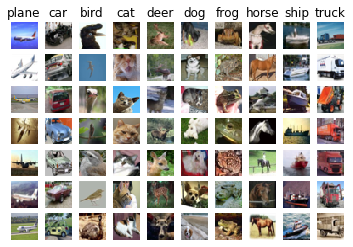

In [5]:
# Visualizing some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

In [6]:
# Subsample the data for more efficient code execution in this exercise
num_training = 10000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [7]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(10000, 3072) (1000, 3072)


In [8]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.ytr = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dist = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dist, k=k)
    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.Xtr.shape[0]
        dists = np.zeros((num_test, num_train))
        # distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
        distances = np.sqrt(np.sum(np.square(self.Xtr), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.Xtr.T))
        return distances
    def predict_labels(self, dist, k=1):
        num_test = dist.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.ytr[np.argsort(dist[i,:])[:k]]
            y_pred[i] = np.argmax(np.bincount(closest_y))
        return y_pred

In [11]:
# k-nearest neighbors classifier
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists= classifier.compute_distances(X_test)

In [12]:
y_pred = classifier.predict(X_test, k=5)
num_correct = np.sum(y_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 296 / 1000 correct => accuracy: 0.296000


In [13]:
def cross_validation(X, y, k_choices, num_folds):
    num_train = X.shape[0]
    num_features = X.shape[1]
    k_to_accuracies = {}
    for k in k_choices:
        k_to_accuracies[k] = []
        for i in range(num_folds):
            mask = np.ones(num_train, dtype=bool)
            mask[i * int(num_train / num_folds) : (i + 1) * int(num_train / num_folds)] = False
            X_train = X[mask]
            y_train = y[mask]
            X_test = X[~mask]
            y_test = y[~mask]
            classifier = KNearestNeighbor()
            classifier.train(X_train, y_train)
            dists = classifier.compute_distances(X_test)
            y_pred = classifier.predict(X_test, k=k)
            num_correct = np.sum(y_pred == y_test)
            accuracy = float(num_correct) / num_test
            k_to_accuracies[k].append(accuracy)
    return k_to_accuracies

In [14]:
cross_validation(X_train, y_train, [5,10], 5)

{5: [0.589, 0.568, 0.595, 0.55, 0.557], 10: [0.605, 0.574, 0.568, 0.532, 0.57]}

In [15]:
class knn(object):
    def __init__(self, k):
        self.k = k
    def fit(self, X, y):
        self.X = X
        self.y = y
    def predict(self, X):
        num_test = X.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y[np.argsort(np.sum(np.square(self.X - X[i,:]), axis = 1))[:self.k]]
            y_pred[i] = np.argmax(np.bincount(closest_y))
        return y_pred